In [16]:
using FastGaussQuadrature, DelimitedFiles, LinearAlgebra, FFTW, RecipesBase, Plots
pyplot()

include("2DRegion_Sphere.jl")

rectsleps

In [17]:
# Helper functions

function sgn(x)
    if x > 0
        return 1
    elseif x < 0
        return -1
    else
        return 0
    end
end

function xcross(p1,y)
    if p1[1,1] == p1[2,1]
        x = p1[1,1]
    else
        m = (p1[1,2] - p1[2,2])/(p1[1,1] - p1[2,1])
        b = (p1[1,2] - m*p1[1,1])
        x = (y-b)/m
    end
    return x
end

function sclxpts(xy,y)
    # find the xy[:,2] points that "best match" (cross) our y val
    upcross = findall(x->x==2, diff(sgn.(xy[:,2].-y)))
    downcross = findall(x->x==-2, diff(sgn.(xy[:,2].-y)))
    xp = [xcross(xy[[upcross[1],upcross[1]+1],:],y), xcross(xy[[downcross[1],downcross[1]-1],:],y)]
    sort!(xp)
    cent = (xp[2]+xp[1])/2
    scl = (xp[2]-xp[1])/2
    return cent, scl
end

function glgrid(xy,noys,nox, wtx, wty)
    out = zeros(length(nox)*length(noys),2)
    w = ones(length(nox)*length(noys))
    for (i,y) in enumerate(noys)
        cent, scl = sclxpts(xy,y)
        out[(i-1)*N+1:i*N,:] = hcat(cent.+ scl.*nox, y*ones(length(nox)))
        w[(i-1)*N+1:i*N] = wty[i]*(wtx*scl)
    end
    return out, w
end

""" Function to plot 2d points that are in the form of nested arrays"""
@recipe function plt2dpts(pts::Array{Array{Float64,1},1})
    p = hcat(pts...)
    dims = size(p)
    legend = false
    @series begin
        p[1,:],p[2,:]
    end
end

function fillwquad(xy,N,M)
    nox, wtx = FastGaussQuadrature.gausslegendre(N)
    noy, wty = FastGaussQuadrature.gausslegendre(M)
    miny,maxy = (minimum(xy[:,2]),maximum(xy[:,2]))

    # Scale the y quadrature points to fill the y-extent
    scly = (maxy-miny)/2
    centy = (maxy+miny)/2

    # Scaled nodes in y direction
    noys = noy*scly .+ centy
    # scaled weights
    wtys = wty*scly 

    intpts,wtv = glgrid(xy,noys,nox,wtx,wtys)
    no = map(i->intpts[i,:],1:size(intpts,1))
    return no,wtv
end

fillwquad (generic function with 1 method)

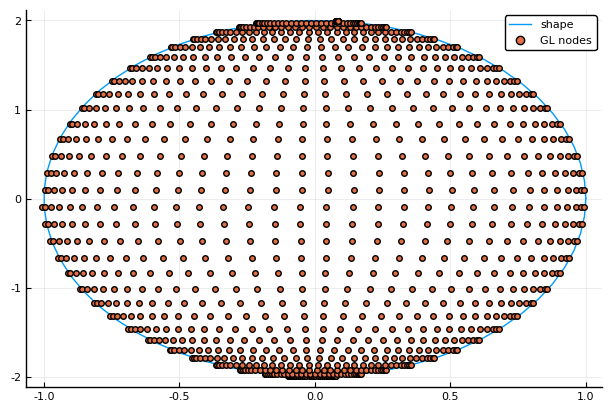

In [29]:
# simply connected shapefile

xy = readdlm("ellipse.txt")

# We need to fill this with quadrature nodes
N,M = 32,32
miny,maxy = (minimum(xy[:,2]),maximum(xy[:,2]))
minx,maxx = (minimum(xy[:,1]),maximum(xy[:,1]))
aspectratio = (maxy-miny)/(maxx-minx)

no,wtv = fillwquad(xy,N,M)

p1 = plot(xy[:,1],xy[:,2],label="shape")
p1 = scatter!(no,label="GL nodes")
# png("GLintegnodes_ellipse")


In [30]:

Kp = 12.0
nslep = 4
verbose = true 

n=64
m=64

# set up the eigenvalue problem and factorize: see eqn (86) of SW2011
  Kf       = Dmatrix(Kp, no, no)
  W        = Diagonal(sqrt.(wtv))
  solvme   = Symmetric(W*Kf*W) 
  factd    = eigen(solvme) # formerly eigfact

  # Extract the slepians, show the concentrations if verbose:
  goodind  = sortperm(factd.values, rev=true)[1:nslep]
  if verbose
    println("The $(nslep) concentrations:")
    for j in 1:nslep
      println(factd.values[goodind[j]])
    end
  end

  # Get the number of requested sleps: see eqn (88) of SW2011
  points   = collect.(collect(Iterators.product(LinRange(minx, maxx, n), LinRange(miny, maxy, m)))[:])
  sleps    = Matrix{Float64}[]
  for l in 1:nslep
    newslep = zeros(Float64, n*m)
    @simd for j in eachindex(points)
      @simd for k in eachindex(no)
        @inbounds newslep[j] += wtv[k]*Dfun(no[k], points[j], Kp)*factd.vectors[:,goodind[l]][k]
      end
    end
    push!(sleps, reshape(newslep, n, m)./factd.values[goodind[l]])
  end


The 4 concentrations:
0.9999999985136444
0.9999999955396021
0.9999999861908782
0.9999999558549998


In [31]:
# The region of concentration in the spectral domain
t = LinRange(0,2*pi,80)
x = sqrt(Kp)*cos.(t)
y = sqrt(Kp)*sin.(t)
# plot(x,y)

80-element Array{Float64,1}:
  0.0
  0.27522345172968
  0.5487068521836628
  0.8187211512506615
  1.0835592315953064
  1.341546701603581
  1.59105248142571
  1.8304991151881302
  2.058372744177418
  2.273232677942491
  2.473720502803504
  2.6585686701804976
  2.8266085104436383
  ⋮
 -2.6585686701804967
 -2.4737205028035043
 -2.2732326779424934
 -2.058372744177417
 -1.8304991151881316
 -1.5910524814257103
 -1.3415467016035831
 -1.083559231595308
 -0.818721151250662
 -0.5487068521836654
 -0.2752234517296787
 -8.484601909799254e-16

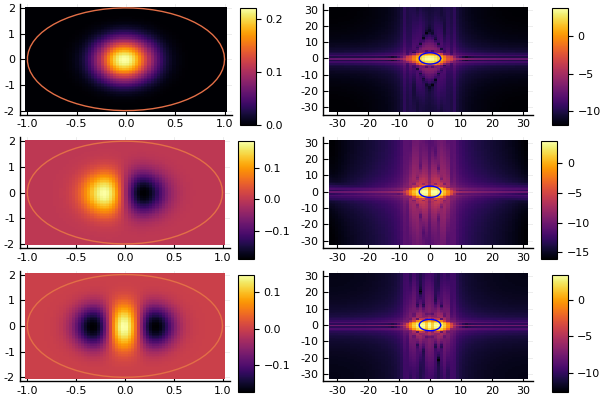

In [35]:
circ = map(y->abs2.(fftshift(fft(sleps[y]))),1:nslep)

n2 = Int64(n/2)
m2 = Int64(m/2)

q1 = heatmap(LinRange(minx, maxx, n), LinRange(miny, maxy, m), sleps[1])
q1 = plot!(xy[:,1],xy[:,2],legend = false)
q2 = heatmap(collect(-n2:(n2-1)),collect(-m2:(m2-1)),log10.(circ[1]))
q2 = plot!(x,y,c=:blue,legend = false)

q3 = heatmap(LinRange(minx, maxx, n), LinRange(miny, maxy, m), sleps[2])
q3 = plot!(xy[:,1],xy[:,2],legend = false)
q4 = heatmap(collect(-n2:(n2-1)),collect(-m2:(m2-1)),log10.(circ[2]))
q4 = plot!(x,y,c=:blue,legend = false)

q5 = heatmap(LinRange(minx, maxx, n), LinRange(miny, maxy, m), sleps[3])
q5 = plot!(xy[:,1],xy[:,2],legend = false)
q6 = heatmap(collect(-n2:(n2-1)),collect(-m2:(m2-1)),log10.(circ[3]))
q6 = plot!(x,y,c=:blue,legend = false)

plot(q1, q2, q3, q4, q5, q6, layout=(3,2))

In [36]:
png("ellipseconc")